In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Github/

[Errno 2] No such file or directory: '/content/drive/MyDrive/Github/'
/content


In [4]:
import os
import sys
dir= "/content/drive/MyDrive//DeepLearning2022-main/ContractReviewer"
os.chdir(dir)

In [5]:
#!pip install bert-pytorch
!pip install sentencepiece
!pip install transformers
!pip install onnx
!pip install fasttext
!pip install torchtext
!pip install scikit-learn
!pip install d2l==1.0.0-alpha1.post0
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.0 MB/s 
     |████████████████████████████████| 7.6 MB 48.2 MB/s 
     |████████████████████████████████| 182 kB 82.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.6 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=3124510 sha256=eb33c92da356d26fe3ebf95e6b1b24ee2a505e3728a6aca18ac0a618e24c1dcc
  Stored in directory: /root/.cache/p

In [6]:
import yaml
import argparse
import time
import copy

import torch
import torchtext
from torchtext import datasets
from torch import nn
from d2l import torch as d2l

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [7]:
import pandas as pd

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.rename(columns={'choice': 'label'}, inplace=True)
test.rename(columns={'choice': 'label'}, inplace=True)

def change_label(x):
  torch.manual_seed(123)

  if x == "Entailment":
    return 0
  elif x == "Contradiction":
    return 1
  else:
    return 2

train["label"] = train.label.apply(lambda x: change_label(x))
test["label"]  = test.label.apply(lambda x: change_label(x))

## Will need to implement FIAS Here to update Train dataset for training

In [8]:
#######################################################################################
#######################################################################################

#TO DO FIAS CODE

#######################################################################################
#######################################################################################

## End implementation of FIAS

In [9]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        torch.manual_seed(123)
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset["hypotheis"])
        all_hypothesis_tokens = d2l.tokenize(dataset["premise"])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset["label"])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        torch.manual_seed(123)
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        torch.manual_seed(123)
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        torch.manual_seed(123)
        return len(self.premises)

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [11]:
def mlp(num_inputs, num_hiddens, flatten):
    torch.manual_seed(123)
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [12]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        torch.manual_seed(123)
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        torch.manual_seed(123)
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [13]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        torch.manual_seed(123)
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        torch.manual_seed(123)
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [14]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        torch.manual_seed(123)
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        torch.manual_seed(123)
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [15]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        torch.manual_seed(123)
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        torch.manual_seed(123)
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

def reweight(cls_num_list, beta=0.9999):
    torch.manual_seed(123)

    """
    Implement reweighting by effective numbers
    :param cls_num_list: a list containing # of samples of each class
    :param beta: hyper-parameter for reweighting, see paper for more details
    :return:
    """
    per_cls_weights = None
    #############################################################################
    # TODO: reweight each class by effective numbers                            #
    #############################################################################
    per_cls_weights = []
    for cls_num in cls_num_list:
        per_cls_weights.append((1 - beta) / (1 - (beta ** cls_num)))         
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    return per_cls_weights


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.1, device='cpu'):
        torch.manual_seed(123)
        super(FocalLoss, self).__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight
        self.device = device

    def forward(self, input, target):
        """
        Implement forward of focal loss
        :param input: input predictions
        :param target: labels
        :return: tensor of focal loss in scalar
        """
        torch.manual_seed(123)
        loss = None
        #############################################################################
        # TODO: Implement forward pass of the focal loss                            #
        #############################################################################
        
        input = input.to(self.device)
        target = target.to(self.device)
        import torch.nn.functional as F
        weight=torch.from_numpy(np.array(self.weight)).float().to(self.device)
        ce_loss = F.cross_entropy(input, target,  weight=weight)
        pt = torch.exp(-ce_loss) 
        foc_loss = ((1 -pt) ** self.gamma * ce_loss)
        loss = foc_loss.mean()
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss

# Hyperparameters


In [17]:
torch.manual_seed(123)


def load_config_notebook():
  class Args:
    num_step = 50
    batch_size= 256
    learning_rate= 0.01
    reg= 0.0001
    epochs= 10
    steps= [6, 8]
    warmup= 0
    momentum= 0.75
    gamma=3
    beta= .75
    max_netural= 5
    save_best= True
    model= DecomposableAttention
    trainer= "Adam" #SGD can be Adam or SGD
    loss= "Focal" #CrossEntropyLoss can be Focal or CrossEntropyLoss

  return Args()

args = load_config_notebook()

## Training Model

loss 0.000, train acc 0.838, test acc 0.825
14781.7 examples/sec on [device(type='cuda', index=0)]


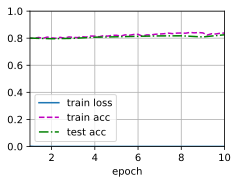

In [18]:
#############################################################
# Create Dataset
#############################################################
torch.manual_seed(123)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_steps = args.num_step
batch_size = args.batch_size
num_workers = d2l.get_dataloader_workers()
train_set = SNLIDataset(train, num_steps)
test_set = SNLIDataset(test, num_steps, train_set.vocab)
vocab = train_set.vocab
train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=False,
                                             num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                        shuffle=False,
                                        num_workers=num_workers)
#############################################################
# Set Up Model and Glove components
#############################################################
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

#############################################################
# Train Model
#############################################################

torch.manual_seed(123)

#reweight labels
a = train.label.value_counts()
cls_num_list = list([a[0],a[1],a[2]])
per_cls_weights =  reweight(cls_num_list, beta=args.beta)
#batch_size, num_steps = 128, 50
#lr, num_epochs = 0.001, 4

#hyperparam criterion
if args.trainer == "Adam":
  trainer = torch.optim.Adam(net.parameters(), lr=args.learning_rate)
else:
  trainer = torch.optim.SGD(net.parameters(), lr=args.learning_rate,\
                            momentum=args.momentum)
#hyperparam loss function
if args.loss == "Focal":
  loss = FocalLoss(weight=per_cls_weights, gamma=args.gamma).to(device)
else:
  loss = nn.CrossEntropyLoss(reduction="none")


d2l.train_ch13(net, train_iter, test_iter, loss, trainer, args.epochs, devices)

## Testing and Prediction

In [19]:
def predict_snli(net, vocab, premise, hypothesis):
    torch.manual_seed(123)
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'Entailment' if label == 0 else 'Contradiction' if label == 1 \
            else 'neutral'

In [20]:
predict_snli(net, vocab, train.iloc[4, :]["premise"].split(), \
             train.iloc[4, :]["hypotheis"].split())

'Entailment'

In [21]:
y_hat=[]
for i in range(len(train)):
    y_hat.append(predict_snli(net, vocab, train.iloc[i, :]["premise"].split(), \
                          train.iloc[i, :]["hypotheis"].split()))
    
    

In [22]:
import collections

frequency = collections.Counter(y_hat)
frequency

Counter({'neutral': 34661, 'Entailment': 7369, 'Contradiction': 18})

In [23]:
y_hat_transformed = [change_label(x) for x in y_hat]

## Metrics

In [24]:
labels = train["label"].values

In [25]:
print(f"\n {classification_report(labels, y_hat_transformed, labels=[0,1,2])}")


               precision    recall  f1-score   support

           0       0.48      0.53      0.50      6759
           1       0.44      0.01      0.01      1578
           2       0.86      0.89      0.88     33711

    accuracy                           0.80     42048
   macro avg       0.60      0.47      0.46     42048
weighted avg       0.79      0.80      0.78     42048



## **Grid Search**

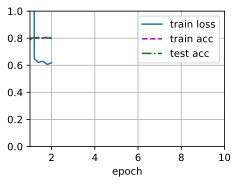

In [ ]:
import pandas as pd

res_dict = {}
res_dict['batch_size'] = []
res_dict['learning_rate'] = []
res_dict['reg'] = []
res_dict['momentum'] = []
res_dict['gamma'] = []
res_dict['beta'] = []
res_dict['max_neutral'] = []
res_dict['optimizer'] = []
res_dict['loss_type'] = []
res_dict['class_0_precision'] = []
res_dict['class_0_recall'] = []
res_dict['class_0_f1'] = []
res_dict['class_1_precision'] = []
res_dict['class_1_recall'] = []
res_dict['class_1_f1'] = []
res_dict['class_2_precision'] = []
res_dict['class_2_recall'] = []
res_dict['class_2_f1'] = []

for batch_size in [64, 128, 256, 512]:
  for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
    for reg in [0.001, 0.0001]:
      for momentum in [0.5, 0.75, 0.9]:
        for gamma in [1, 2, 3]:
          for beta in [0.75, 0.9, 0.99, 0.999]:
            for max_neutral in [5, 10, 15]:
              for optimizer in ['Adam', 'SGD']:
                for loss_type in ['Focal', 'CE']:

                    print("Experimenting with", \
                          "batch_size:", batch_size, \
                          ", learning_rate:", learning_rate, \
                          ", momentum:", momentum, \
                          ", gamma:", gamma, \
                          ", beta:", beta, \
                          ", max_neutral:", max_neutral, \
                          ", optimizer:", optimizer, \
                          ", loss_type:", loss_type)
                    #############################################################
                    # Create Dataset
                    #############################################################
                    torch.manual_seed(123)
     
                    device = 'cuda' if torch.cuda.is_available() else 'cpu'
                    num_steps = 50
                    batch_size = batch_size
                    num_workers = d2l.get_dataloader_workers()
                    train_set = SNLIDataset(train, num_steps)
                    test_set = SNLIDataset(test, num_steps, train_set.vocab)
                    vocab = train_set.vocab
                    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                                             shuffle=False,
                                                             num_workers=num_workers)
                    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                                             shuffle=False,
                                                             num_workers=num_workers)
               
                    #############################################################
                    # Set Up Model and Glove components
                    #############################################################
                    embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
                    net = DecomposableAttention(vocab, embed_size, num_hiddens)
                    glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
                    embeds = glove_embedding[vocab.idx_to_token]
                    net.embedding.weight.data.copy_(embeds);
 
                    #############################################################
                    # Train Model
                    #############################################################
 
                    torch.manual_seed(123)
 
                    #reweight labels
                    a = train.label.value_counts()
                    cls_num_list = list([a[0],a[1],a[2]])
                    per_cls_weights =  reweight(cls_num_list, beta=beta)
 
                    #hyperparam criterion
                    if optimizer == "Adam":
                       trainer = torch.optim.Adam(net.parameters(), lr=learning_rate)
                    else:
                       trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
 
                    #hyperparam loss function
                    if loss_type == "Focal":
                      loss = FocalLoss(weight=per_cls_weights, gamma=gamma).to(device)
                    else:
                      loss = nn.CrossEntropyLoss(reduction="none")

                    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

                    predict_snli(net, vocab, train.iloc[4, :]["premise"].split(), \
                                             train.iloc[4, :]["hypotheis"].split())
                   
                    y_hat=[]
                    for i in range(len(train)):
                        y_hat.append(predict_snli(net, vocab, train.iloc[i, :]["premise"].split(), \
                                                             train.iloc[i, :]["hypotheis"].split()))
    
                    frequency = collections.Counter(y_hat)
                    y_hat_transformed = [change_label(x) for x in y_hat]

                    labels = train["label"].values

                    df = pd.DataFrame(classification_report(labels, y_hat_transformed, labels=[0,1,2], output_dict = True))
                    
                    class_0_precision = df['0']['precision']
                    class_0_recall = df['0']['recall']
                    class_0_f1 = df['0']['f1-score']
                    class_1_precision = df['1']['precision']
                    class_1_recall = df['1']['recall']
                    class_1_f1 = df['1']['f1-score']
                    class_2_precision = df['2']['precision']
                    class_2_recall = df['2']['recall']
                    class_2_f1 = df['2']['f1-score']

                    res_dict['batch_size'].append(batch_size)
                    res_dict['learning_rate'].append(learning_rate)
                    res_dict['reg'].append(reg)
                    res_dict['momentum'].append(momentum)
                    res_dict['gamma'].append(gamma)
                    res_dict['beta'].append(beta)
                    res_dict['max_neutral'].append(max_neutral)
                    res_dict['optimizer'].append(optimizer)
                    res_dict['loss_type'].append(loss_type)

                    res_dict['class_0_precision'].append(class_0_precision)
                    res_dict['class_0_recall'].append(class_0_recall)
                    res_dict['class_0_f1'].append(class_0_f1)

                    res_dict['class_1_precision'].append(class_1_precision)
                    res_dict['class_1_recall'].append(class_1_recall)
                    res_dict['class_1_f1'].append(class_1_f1)

                    res_dict['class_2_precision'].append(class_2_precision)
                    res_dict['class_2_recall'].append(class_2_recall)
                    res_dict['class_2_f1'].append(class_2_f1)

                    res_df = pd.DataFrame(res_dict)
                    res_df.to_csv('res_df.csv')
                    display(res_df)

In [46]:
res_df

NameError: ignored